# DengAI: Predicting Disease Spread

## Purpose

This competition is hosted by DrivenData [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread). The purpose of the competition is to predict the number of cases of Dengue Fever in two cities: San Juan, Puerto Rico, and Iquitos, Peru.

## Data

The projects gives three datasets: features training, labels training, and features testing. The features are:

- **city** "sj" for San Juan, or "iq" for iquitos
- **year** 
- **weekofyear** 1 - 53
- **week_start_date** format: YYYY-MM-DD
- **ndvi_ne** (satellite vegation index) pixel northeast of city
- **ndvi_nw** (satellite vegation index) pixel northwest of city
- **ndvi_se** (satellite vegation index) pixel southeast of city
- **ndvi_sw** (satellite vegation index) pixel southwest of city
- **precipitation_amt_mm** (satellite) precipitation in mm, (*note*: same as reanalysis_sat_precip_amt_mm)
- **reanalysis_air_temp_k** (satellite) "mean" air temp in K (different from average)
- **reanalysis_avg_temp_k** (satellite) "average" air temp in K
- **reanalysis_dew_point_temp_k** (satellite) dew point in K
- **reanalysis_max_air_temp_k** (satellite) max temp in K
- **reanalysis_min_air_temp_k** (satellite) min temp in K
- **reanalysis_precip_amt_kg_per_m2** (satellite) precipitation, kg per m^2
- **reanalysis_relative_humidity_percent** (satellite) relative humidity percent 1 - 00
- **reanalysis_sat_precip_amt_mm** (satellite) precipitation in mm, (*note*: same as precipitation_amt_mm)
- **reanalysis_specific_humidity_g_per_kg** (satellite) humidity, g per kg
- **reanalysis_tdtr_k** (satellite) diurnal temperature (difference between max and min)
- **station_avg_temp_c** (station) average temperature in C
- **station_diur_temp_rng_c** (station) diurnal temperature range in C
- **station_max_temp_c** (station) max temperature in C
- **station_min_temp_c** (station) min temperature in C
- **station_precip_mm** (station) mm of precipitation
- **total_cases** total number of cases that week

# Facts

### Dengue Fever
- Dengue Fever is mosquito-borne. It is *not* contagious.
- There are 4 serotypes of Dengue Fever. When someone is infected with one and recovers, he/she maintains immunity to that serotype.
- Incubation period is 4-10 days.

### Mosquitos
- The life-cycle of a mosquito is usually 7-14 days but depends on temperature.

### Other Factors

We have to be reasonable in our expectations. There are other factors that influence mosquito populations. One example is spraying. We do not have any information as to when pesticides were used to keep down the mosquito populations. All we have to work with is weather data.

Sources:
[WHO](http://www.who.int/denguecontrol/human/en)
[EPA](https://www.epa.gov/mosquitocontrol/mosquito-life-cycle)

# Exploring the Data

### Import and Preprocess

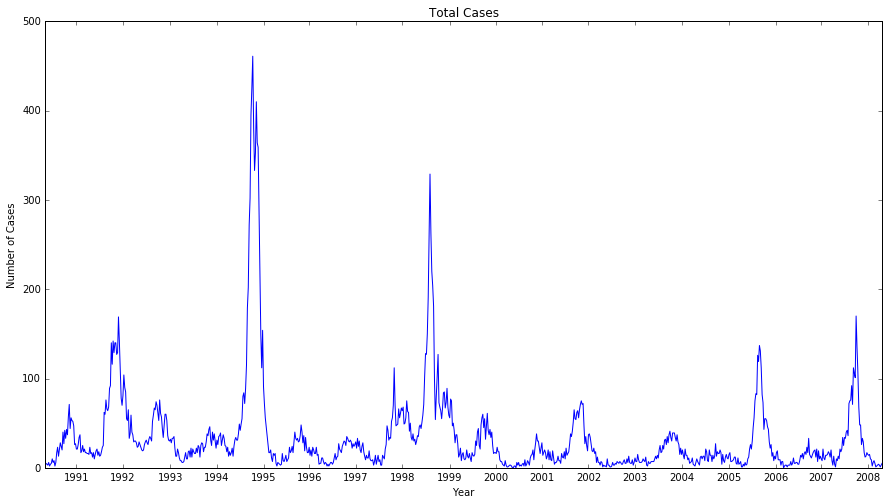

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8) # for Jupyter notebook sizing

train_data = pd.read_csv('data/dengue_features_train.csv')
labels_data = pd.read_csv('data/dengue_labels_train.csv')
test_data = pd.read_csv('data/dengue_features_test.csv')

def preprocess(data, labels = None):
    if(labels is not None):
        data['total_cases'] = labels['total_cases']
    
    sj = data[data.city == 'sj'].copy()
    iq = data[data.city == 'iq'].copy()
    
    sj = sj.drop(['city', 'week_start_date'], axis = 1)
    iq = iq.drop(['city', 'week_start_date'], axis = 1)
    
    return sj, iq.reset_index(drop = True)

sj_train, iq_train = preprocess(train_data, labels_data)
sj_test, iq_test = preprocess(test_data)

plt.figsize = (15, 8)
plt.title('Total Cases')
plt.xticks([i for i, w in enumerate(sj_train['weekofyear']) if w == 1], range(1991, 2009))
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.plot(sj_train['total_cases'])
plt.show()

You can see the number of cases has a cycle every year, which peaks toward the end of summer. Let's explore the seasonality.

## Seasonality

To begin, we can extract the seasonality out of the number of cases. We will do this by computing the mean (or median) number of cases for each week, 1 through 53.

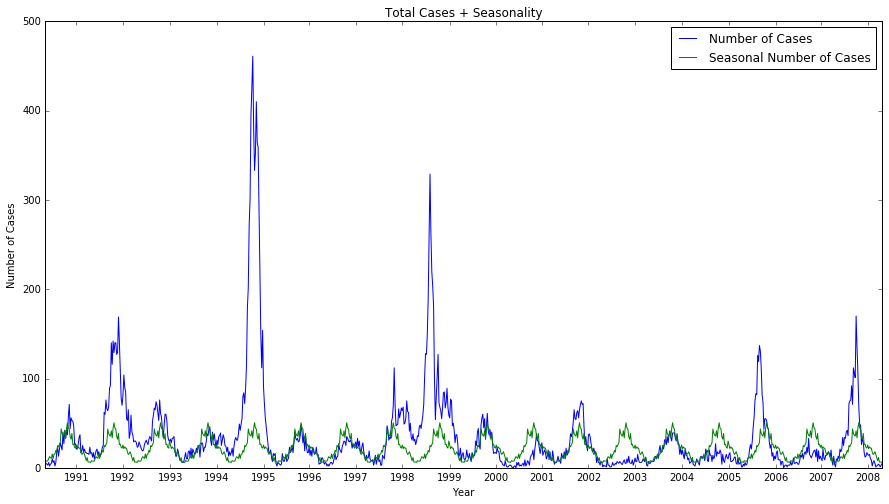

In [3]:
def seas_adj(df, x, week_path = False, m = 'median'):
    if m == 'mean':
        weekly = [df[x][df['weekofyear'] == i].mean() for i in range(1,54)]
    elif m == 'median':
        weekly = [df[x][df['weekofyear'] == i].median() for i in range(1,54)] 
    
    seasonality = [weekly[w - 1] for w in df['weekofyear']]
    adjusted = np.subtract(df[x], seasonality)
    
    if(week_path):
        return seasonality, adjusted, weekly
    
    return seasonality, adjusted

sj_season, sj_adj, sj_means = seas_adj(sj_train, 'total_cases', week_path = True)
iq_season, iq_adj, iq_means = seas_adj(iq_train, 'total_cases', week_path = True)

plt.title('Total Cases + Seasonality')
plt.xticks([i for i, w in enumerate(sj_train['weekofyear']) if w == 1], range(1991, 2009))
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.plot(sj_train['total_cases'])
plt.plot(sj_season)
plt.legend(labels = ['Number of Cases', 'Seasonal Number of Cases'])
plt.show()

As you can see, seasonality alone misses the spikes in cases. These epidemic will have to be accounted for somehow. After submitting the seasonality into DrivenData, the mean absolute error was 26. Using any sort of regression as-is will return a similar pattern. The trick to this competition is going to be predicting the epidemics, or spikes, in the data.

## Total cases by week

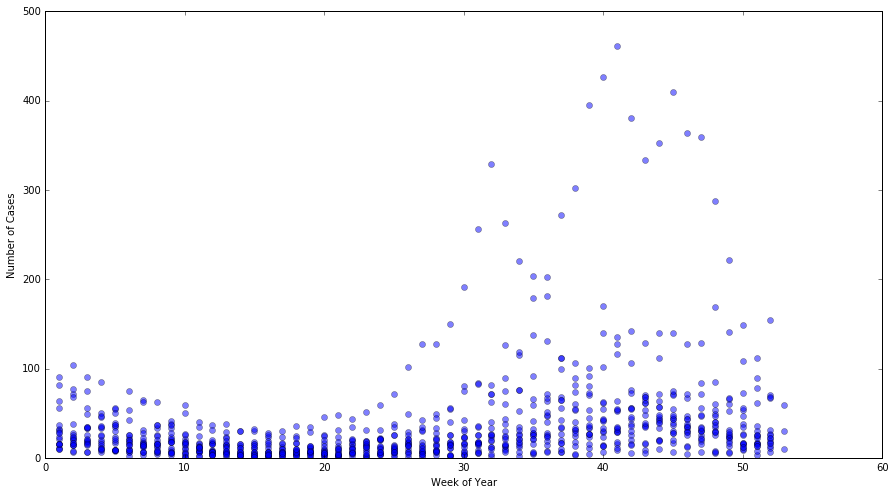

In [24]:
plt.plot(sj_train ['weekofyear'], sj_train['total_cases'], 'bo', alpha = .5)
plt.xlabel('Week of Year')
plt.ylabel('Number of Cases')
plt.show()

Most epdemics are in weeks 25 - 53.

## Vegetation Index

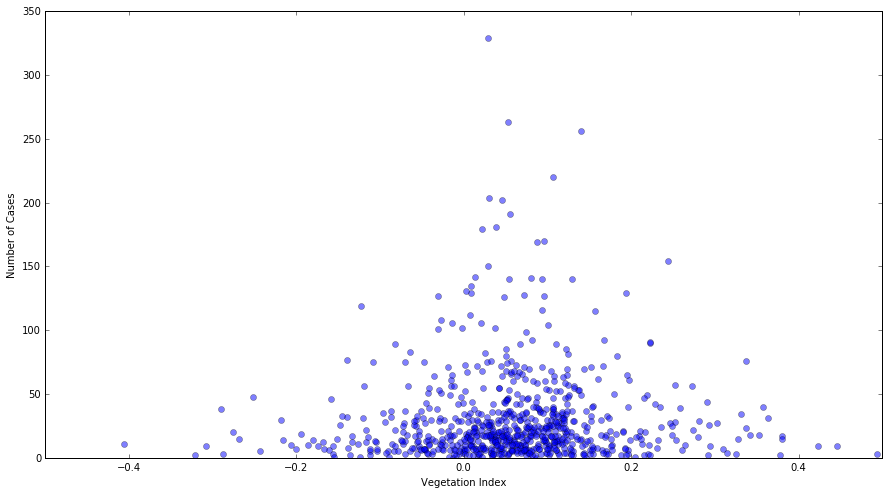

In [25]:
plt.plot(sj_train['ndvi_ne'], sj_train['total_cases'], 'bo', alpha = .5)
plt.xlabel('Vegetation Index')
plt.ylabel('Number of Cases')
plt.show()

All of the vegetation index variables show a similar relationship with the number of cases. This relationship is not linear (does not have correlation), but might prove to be important.

## Precipitation

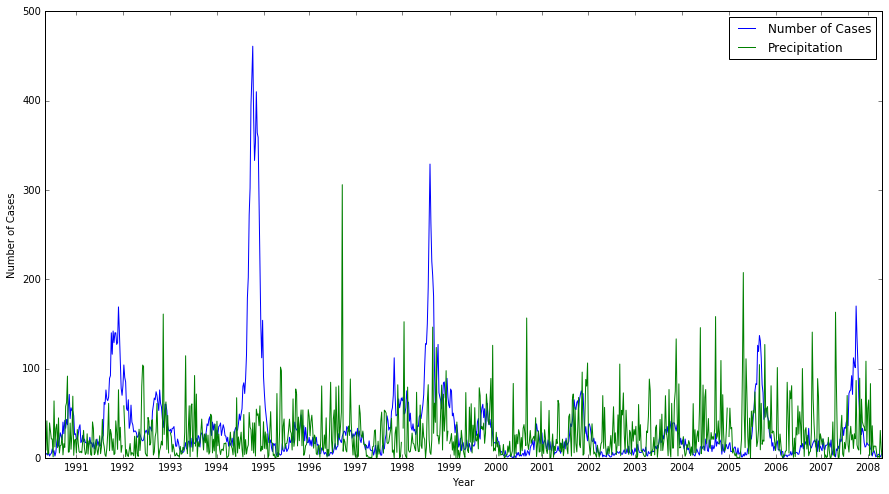

In [25]:
plt.xticks([i for i, w in enumerate(sj_train['weekofyear']) if w == 1], range(1991, 2009))
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.plot(sj_train['total_cases'])
plt.plot(sj_train['station_precip_mm'])
plt.legend(['Number of Cases', 'Precipitation'])
plt.show()

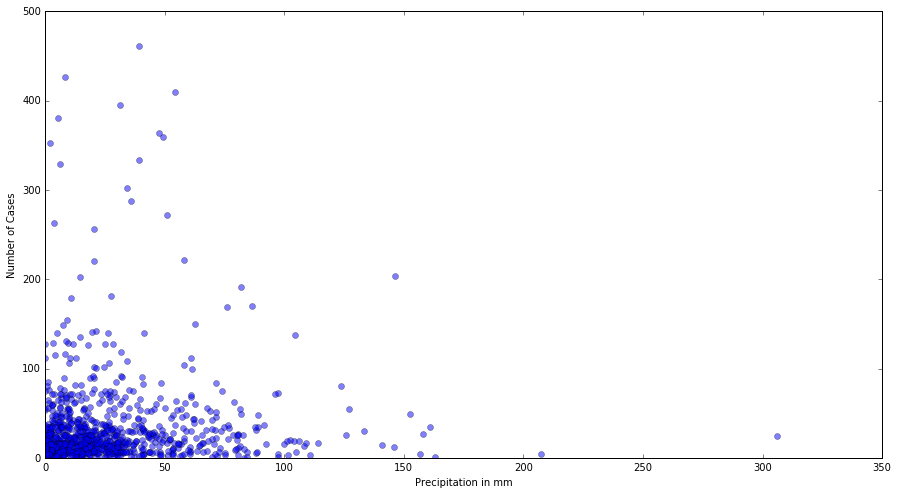

In [29]:
plt.plot(sj_train['station_precip_mm'], sj_train['total_cases'], 'bo', alpha = .5)
plt.xlabel('Precipitation in mm')
plt.ylabel('Number of Cases')
plt.show()

Precipitation plays a crucial role in mosquito development. However, this relationship is not simple. Cases tend to be low above a certain threshold of rainfall. This could be due to too much rainfall causing water to move and become inhospitable to mosquitos. 

Also, drought conditions could play a potential role in mosquito development in some places. This is, potentially, due to people placing containers outside to collect rainwater, which can become home to mosquitos. According to the graph of precipitation over time, it seems that long term reduction in rainfall may lead to an epidemic.

## Temperature

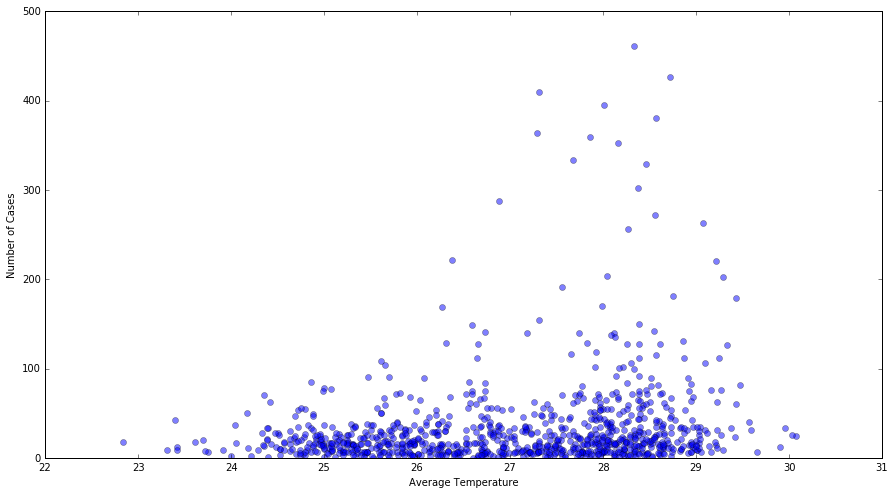

In [35]:
plt.plot(sj_train['station_avg_temp_c'], sj_train['total_cases'], 'bo', alpha = .5)
plt.xlabel('Average Temperature')
plt.ylabel('Number of Cases')
plt.show()

Mosquitos thrive in temperatures above 26 C. This is reflected here.

## Correlation

The correlation plot shows that none of the variables are highly correlated with the number of cases. This makes sense due to the nature of our time series. For example, if a patient goes to the hospital with a case of Dengue Fever, the rainfall that day is mostly irrelevant. What we need to find is the pattern of rainfall that led up to the event.

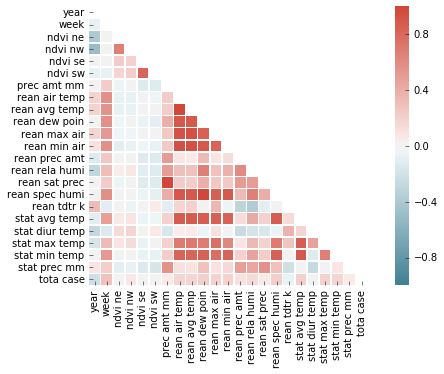

In [15]:
corr = sj_train.corr()

labels = [' '.join([l[:4] for l in label.split('_')][:3]) for label in sj_train.columns]

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (10, 5))

cmap = sns.diverging_palette(220, 15, 75, as_cmap = True)

heatmap = sns.heatmap(corr, mask = mask, cmap = cmap, center = 0, square = True, vmax = 1, vmin = -1, linewidths = .5, xticklabels = labels, yticklabels = labels)

plt.show()

# Missing Data

We will use forward filling (pandas .ffill() function) to fill in missing values. There is a cluster of data missing for the vegetation index for San Juan. This will mean omitting those values for the time being. In the future, we might be able to improve the algorithm by filling in the missing values with predicted values.

# Re-defining the Problem

We now have the seasonality in the cases. If any given year follows the typical seasonal pattern, it is trivial to predict how many cases there will be. However, this method is error prone (at least 24 MAE). Therefore, the problem must be re-defined. What we want is to predict *epidemics* then predict *cases*. If we believe there will be an epidemic, we will use a different method to predict the number of cases. Otherwise, we can assume a seasonal value.

# Feature Engineering

## Removing seasonality

We will be removing the seasonality from the data, if necessary, to increase the correlation between the data and the number of cases. We can utilize pandas *diff()* function to subtract the values over daily, weekly, or yearly time periods.

## Rolling Variables

To tackle the low correlation problem, we will use rolling variables (mean, min, max, etc) and pandas *rolling()* function. The rolling function takes a "window" of values leading up to the current value. Since our data is in weeks, the window is the number of weeks of values before the current date. Back to our rainfall problem: now we can try to determine what statistic of the rainfall and in what time period leading up to the patient going into the hospital had the greatest effect. Maybe total rainfall over the last 12 weeks. Or average rainfall over the past 6 months. We'll let the code do the work for us.

The code for the function can be found HERE.

Let's take the station minimum temperate for example. Here is the temperature without any modifications:

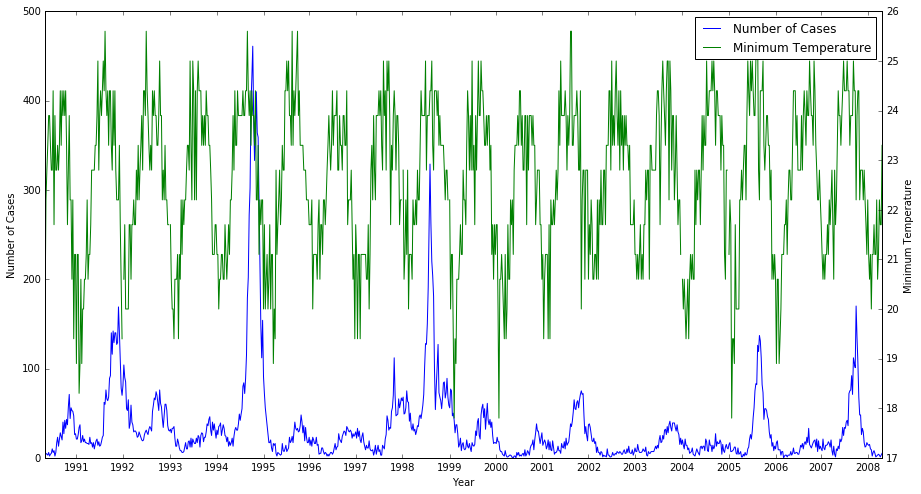

In [37]:
fig, ax = plt.subplots()

plt.xticks([i for i, w in enumerate(sj_train['weekofyear']) if w == 1], range(1991, 2009))
plt.xlabel('Year')

ax.set_ylabel('Number of Cases')
c, = ax.plot(sj_train['total_cases'], color = 'b')

ax2 = ax.twinx()
ax2.set_ylabel('Minimum Temperature')
t, = ax2.plot(sj_train['station_min_temp_c'], color = 'g')

plt.legend([c, t], ['Number of Cases', 'Minimum Temperature'])

We can see the seasonality, but nothing really stands out during the epidemics.

Here is the plot of the the minimum temperature where we have:

1. Removed yearly seasonality
2. Used a window of 45 weeks
3. Calculated
the mean within that window

(we will remove the first year of values before creating our models)

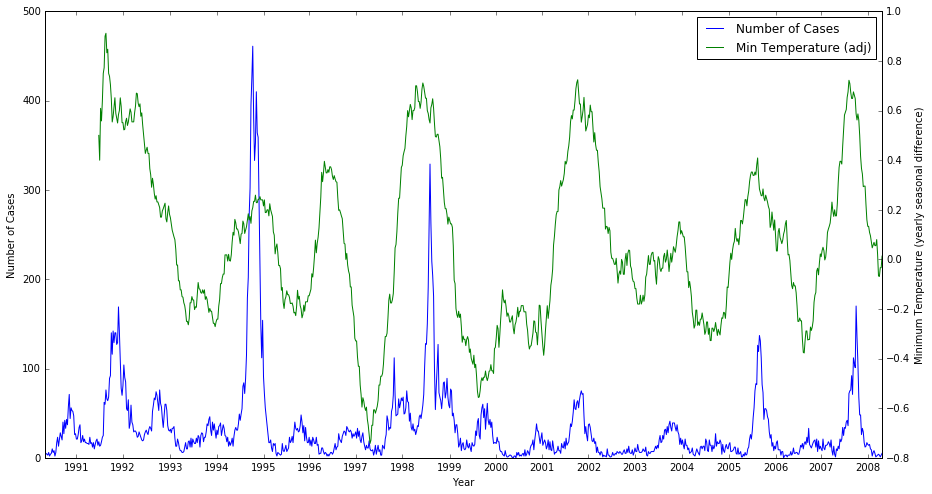

In [41]:
#sj_train['station_min_temp_c'].diff(52).rolling(45, min_periods = 1).mean().tail(-60).plot()
#sj_train['total_cases'].plot(secondary_y = True)

fig, ax = plt.subplots()

plt.xticks([i for i, w in enumerate(sj_train['weekofyear']) if w == 1], range(1991, 2009))
plt.xlabel('Year')

ax.set_ylabel('Number of Cases')
c, = ax.plot(sj_train['total_cases'], color = 'b')

ax2 = ax.twinx()
ax2.set_ylabel('Minimum Temperature (yearly seasonal difference)')
t, = ax2.plot(sj_train['station_min_temp_c'].diff(52).rolling(45, min_periods = 1).mean().tail(-60), color = 'g')

plt.legend([c, t], ['Number of Cases', 'Min Temperature (adj)'])

Here, the temperature matches more closely with the number of cases. It makes sense that the minimum temperature has an effect on the number of cases because too low of a temperature reduces mosquitoes' survivability.